#Description:
In this notebook, we will explore SARIMA model's usability in weather forecasting



#Part 1: Data Preparation

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [26]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/datasets/weather"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
istanbul_historical_weather.csv


In [27]:
#Reading data from Google Drive
#This dataset is private, so I cannot share
weather = pd.read_csv("drive/MyDrive/Colab Notebooks/datasets/weather/istanbul_historical_weather.csv", on_bad_lines='skip')
weather = weather[['datetime','temp', 'humidity', 'windspeed']]
weather = weather.dropna(subset=['temp'])
weather.dtypes

datetime      object
temp         float64
humidity     float64
windspeed    float64
dtype: object

We need to group each month and take averages. Even though the initial plan was to make daily prediction using a SARIMA model, using 365 as seasonality parameter is too much for the model to reasonably work (even Google Colab Pro is not able to meet the RAM requirement and calculations require 1+ hour)

In [28]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.rename(columns={'temp': 'temperature', 'datetime': 'date'})
weather = weather.resample('M', on='date').mean()
weather.reset_index(inplace=True)
weather.head(2)

,date,temperature,humidity,windspeed
0,1991-01-31,5.848387,79.2,27.800000
1,1991-02-28,4.782143,77.1,28.757143


Data description:

* date: YYYY-MM-DD

* temperature: average temperature in Istanbul at the given date, in degrees Celcius

* humidity: average humiditiy in Istanbul at the given date, as percentage

* windspeed: average windspeed in kilometers per hour


Text(0.5, 1.0, "Istanbul's Monthly Averate Temperature Data")

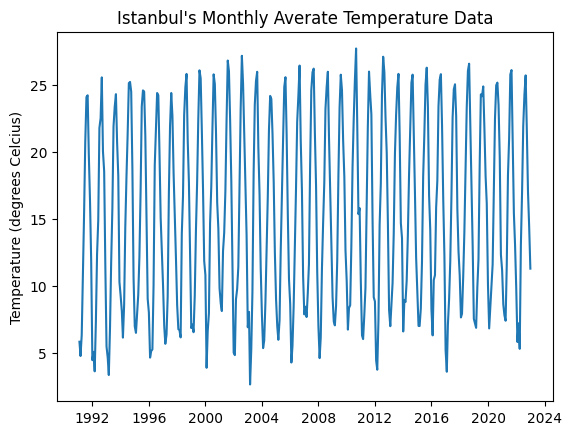

In [29]:
plt.plot(weather.set_index('date')['temperature'])
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Istanbul's Monthly Averate Temperature Data")

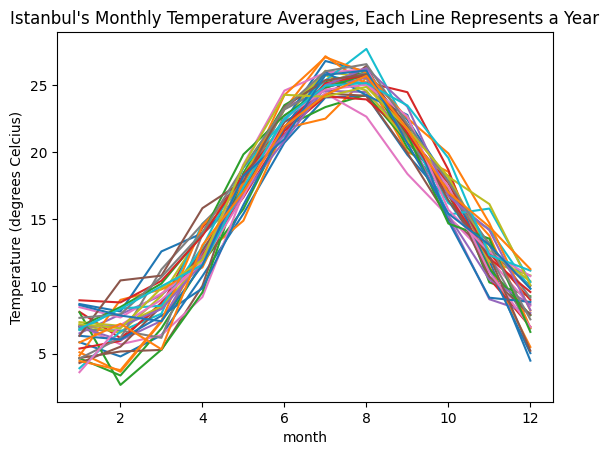

In [30]:
weather_seperated = weather.copy(deep=True)
weather_seperated = weather_seperated[['date', 'temperature']]
weather_seperated['year'] = weather_seperated['date'].dt.year
weather_seperated['month'] = weather_seperated['date'].dt.month
weather_seperated.drop(['date'], axis=1, inplace=True)
weather_seperated = weather_seperated.pivot_table(index='month',  columns='year', values='temperature')

weather_seperated.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Istanbul's Monthly Temperature Averages, Each Line Represents a Year")
plt.legend().remove()
plt.show()

From the chart, we can see monthly temperature averages follow a meaningful seasonal trend.

Note: legend is removed as there are 32 years

In [31]:
#Taking a deep copy of the weather DataFrame
weather_linear = weather.copy(deep=True)
weather_linear['month'] = pd.DatetimeIndex(weather_linear['date']).month

#One-hot-encoding of month data
weather_linear = pd.get_dummies(weather_linear, columns = ['month'])
weather_linear.head(2)

,date,temperature,humidity,windspeed,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1991-01-31,5.848387,79.2,27.800000,1,0,0,0,0,0,0,0,0,0,0,0
1,1991-02-28,4.782143,77.1,28.757143,0,1,0,0,0,0,0,0,0,0,0,0


#Part 2: Predicting with a Simple Model

We will check if a simple linear model is enough to predict monthly averages.

In [32]:
#Fitting a linear regression to data from 1991 to 2018, using 2019 to 2022 as test set
train_data =  weather_linear[weather_linear['date'] < '2019-01-01']
test_data = weather_linear[weather_linear['date'] >= '2019-01-01']
regression = LinearRegression().fit(train_data.iloc[:,-12:], train_data['temperature'])


In [33]:
weather_pred = regression.predict(test_data.iloc[:,-12:])
test_data['prediction'] = weather_pred
print("Mean squared error: %.3f" % mean_squared_error(test_data['temperature'], weather_pred))

print("Coefficient of determination: %.3f" % r2_score(test_data['temperature'], weather_pred))
test_data.head(2)


Mean squared error: 2.292
Coefficient of determination: 0.947


,date,temperature,humidity,windspeed,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,prediction
336,2019-01-31,7.187097,72.780645,21.270968,1,0,0,0,0,0,0,0,0,0,0,0,6.359375
337,2019-02-28,6.885714,76.339286,20.321429,0,1,0,0,0,0,0,0,0,0,0,0,6.390625


The model did a great job in predicting the monthly average temperatures and yielded 0.957 R-square (explained 95.7% of the variance).

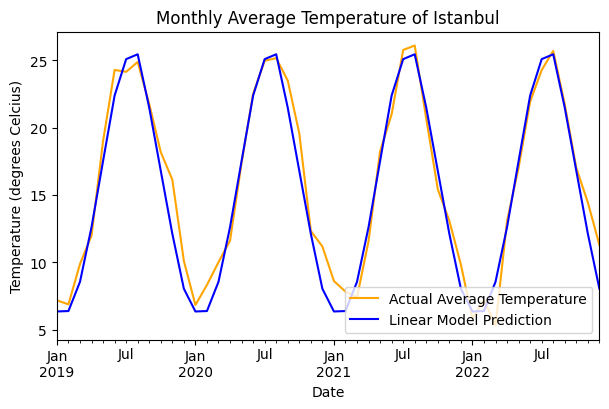

In [34]:
#Plotting actual temperatures vs. predictions of the linear model (using month of year as features)
test_data.set_index('date', inplace=True)
plt.figure(figsize=(7, 4), dpi=100)

test_data['temperature'].plot(label='Actual Average Temperature', color='orange')
test_data['prediction'].plot(label='Linear Model Prediction', color='blue')

plt.title('Monthly Average Temperature of Istanbul')
plt.xlabel('Date')
plt.ylabel('Temperature (degrees Celcius)')

plt.legend(loc='lower right')

#Part 3: SARIMA Model

At this part, we will explore the SARIMA model and check if it performs better.

Initially we are running a Dickey-Fuller test to check weather the time series is stationary. The result shows that we can safely assume that the series is stationary.

In [35]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(weather['temperature']))


Dickey-Fuller Test indicates:
Test Statistic                  -5.330390
p-value                          0.000049
#Lags Used                      17.000000
Number of Observations Used    366.000000
dtype: float64
None


Later, we check partial correlation to decide our autocorrelation constant (p). From the chart, it seems we can use up to 5-month prior data in predicting this month’s average temperature.

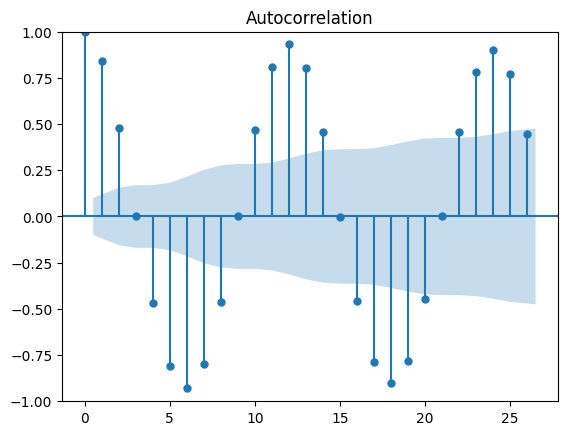

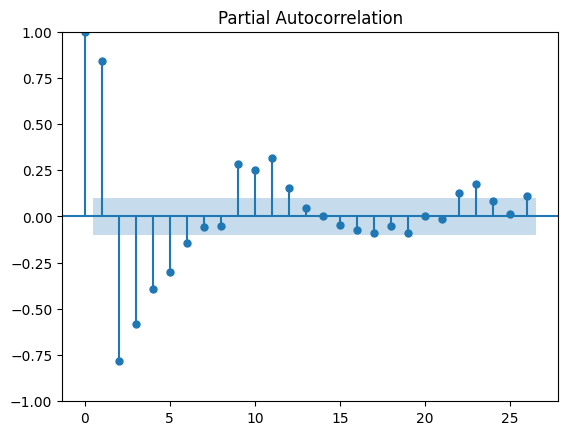

In [36]:
plot_acf(weather['temperature'])
plt.show()
plot_pacf(weather['temperature'])
plt.show()

In [37]:
train_data_SARIMA = weather[weather['date'] < '2019-01-01']
test_data_SARIMA = weather[weather['date'] >= '2019-01-01']
train_data_SARIMA.head(2)

,date,temperature,humidity,windspeed
0,1991-01-31,5.848387,79.2,27.800000
1,1991-02-28,4.782143,77.1,28.757143


Our analysis showed that our data is stationary, so we can use d=0 and D=1 in case there is annual trend in some sort (just to be on the safe side). Partial autocorrelation chart is showing that data points up to 5 timesteps prior can be meaningfully helpful in prediction. The autocorrelation function is showing that we can use a large q, but q=3 and Q=1 yielded good performance. However, after trying several fits, we got statistically significant parameters at (2,0,1).(0,1,1,12)

In [38]:
model = sm.tsa.statespace.SARIMAX(train_data_SARIMA['temperature'],
                         order=(2, 0, 1),
                         seasonal_order=(0, 1, 1, 12))
result = model.fit()
print(result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  336
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -568.960
Date:                            Wed, 09 Aug 2023   AIC                           1147.920
Time:                                    17:34:13   BIC                           1166.824
Sample:                                         0   HQIC                          1155.466
                                            - 336                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1026      0.119      9.297      0.000       0.870       1.335
ar.L2         -0.1670      0.080   

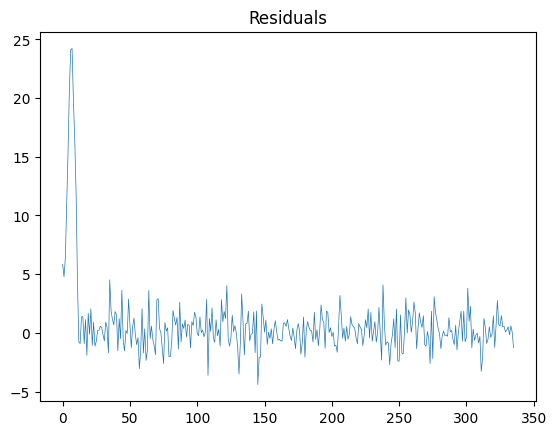

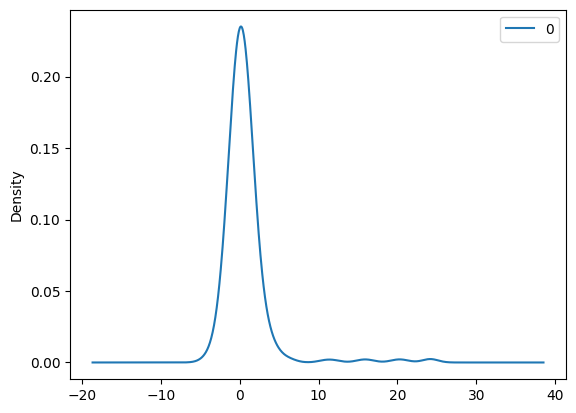

In [39]:
#Checking for obvious patterns in residuals. Any pattern is a bad sign.
residuals = pd.DataFrame(result.resid)
residuals.plot(linewidth=0.5, legend=None)
plt.title('Residuals')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

Also, the residuals seems to have no observable trend, showing a good fit.

Using one-step-ahead predictions, the fit is as follows:

Size of data is 1536 and train set size is 1512


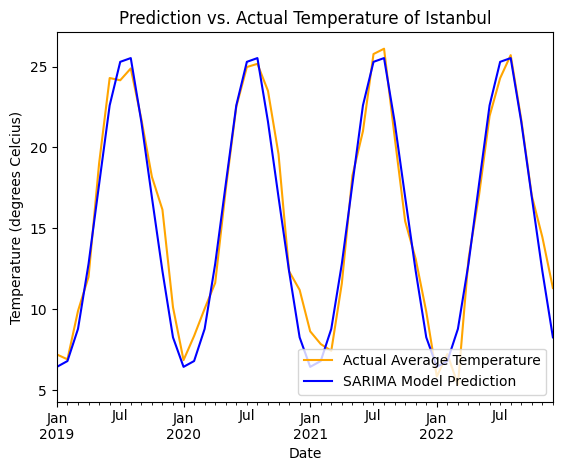

In [40]:
#Training the model again after each prediction, making one-step-ahead prediction each time
print(f'Size of data is {weather.size} and train set size is {weather.size-24}')
one_step_predictions = []
for i in range(48):
  cut_point = weather.size - 24 + i
  model = sm.tsa.statespace.SARIMAX(train_data_SARIMA['temperature'][:cut_point],
                         order=(2, 0, 1),
                         seasonal_order=(0, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
  result = model.fit()
  one_step_predictions.append(result.predict(cut_point).values[0])

test_data_SARIMA['prediction'] = one_step_predictions
test_data_SARIMA.set_index('date', inplace=True)
test_data_SARIMA['temperature'].plot(label='Actual Average Temperature', color='orange')
test_data_SARIMA['prediction'].plot(label='SARIMA Model Prediction', color='blue')
plt.title("Prediction vs. Actual Temperature of Istanbul")
plt.xlabel('Date')
plt.ylabel('Temperature (degrees Celcius)')

plt.legend(loc='lower right')

Now, calculating R-square performance:

In [48]:
test_data_SARIMA['SSRes'] = (test_data_SARIMA['temperature'] - test_data_SARIMA['prediction'])**2
mean_temp = test_data_SARIMA['temperature'].mean()
test_data_SARIMA['SSTot'] = (test_data_SARIMA['temperature'] - mean_temp)**2
r2_SARIMA = 1 - (test_data_SARIMA['SSRes'].sum() / test_data_SARIMA['SSTot'].sum())
print(f'Coefficient of determination: {r2_SARIMA:.3f}')

Coefficient of determination: 0.952


In [63]:
r2_linear = r2_score(test_data['temperature'], weather_pred)

print(f'SARIMA model explained {(r2_SARIMA/r2_linear -1)*100:.3f}% more variance in temperature data')



SARIMA model explained 0.478% more variance in temperature data


#Conclusion

SARIMA model slightly outperformed the simple linear regression in monthly weather prediction task. The potential reason of the small improvement is: autoregressive analysis can be useful for daily data, but monthly average is extremely dependent on the month feature and SARIMA model is not able to meaningfully beat it.
The study showed 3 shortcomings of SARIMA model:
1.	Even though SARIMA model might be working fine with daily data, using 365 as seasonality increases the computing time to non-feasible space. That is the possible reason that nearly all examples in the internet uses monthly or quarterly data.
2.	SARIMA model is good at 1-step-ahead predictions as value at t=10 is dependent to value at t=9. That means fitting the model again for each prediction using all data before that prediction and it makes the process more computationally expensive.
3.	Additionally, SARIMA model is good for one-step-ahead predictions. Therefore, we require to train the model again for each prediction time-step.
